# Regression

## Introduction

In this tutorial, we will be using the Theil-Sen estimator to create differentially private regressions. 

The Theil-Sen estimator is a robust method to fit a line to sample points by **choosing the median of the slopes between each piar of points in the data**. Some of the advantages Theil-Sen has compared to ordinary least squares regression are that it is insensitive to outliers, significantly more accurate for skewed and heteroskedastic data, and fast algorithms for efficiently computing its parameters. It's been labled as "the most popular nonparametric technique for estimating a linear trend."

Source: [Wikipedia](https://en.wikipedia.org/wiki/Theil–Sen_estimator), [University of Virgina StatLab](https://library.virginia.edu/data/articles/theil-sen-regression-programming-and-understanding-an-outlier-resistant-alternative-to-least-squares)

Let's get started! We will only need a few libraries for this tutorial. This tutorial has two parts: 

1. Define the Regression Functions 
2. Apply DP Regression on Synthetic Data

In [88]:
import opendp.prelude as dp
import numpy as np
import polars as pl 
import matplotlib.pyplot as plt

#TODO: change these to contrib or leave as is?
dp.enable_features("honest-but-curious")
dp.assert_features("honest-but-curious")

## Defining Regression Functions

We will define a series of functions and then compose them create a pipeline to compute a differentially private regression.

### 1) Define Alphas

The following code defines alpha values that represent the 25th and 75th percentiles of the distribution of slopes computed from the random points in the dataset. 

We chose the 25th and 75th percentiles because provide a nuanced understanding of the variability present in the dataset, but you can choose any that work best for your specific case.

In [50]:
alphas = np.array([[0.25], [0.75]])

### 2) Define a Function to Compute Points on the Percentile Lines

This function partitions a dataset into random pairs, calculates a slope and midpoint for each pair, and then outputs a set of points that represent the y-values at the specified percentiles (25th and 75th). 

In [51]:
def f_match(data):
    #get an even number of rows
    data = np.array(data, copy=True)[:len(data) // 2 * 2]
    #shuffle the data for robustness
    np.random.shuffle(data)
    #split the data into pairs
    p1, p2 = np.array_split(data, 2)
    #compute differences
    dx, dy = (p2 - p1).T
    #compute slopes
    slope = dy / dx
    x_bar, y_bar = (p1 + p2).T / 2
    #compute points on line of percentiles
    points = slope * (alphas - x_bar) + y_bar
    #keep only pairs where the x difference is positive
    return points.T[dx > 0]


### 3) Define a Function to Compute Differentially Private Percentiles

The make_theil_sen_percentiles function sets up a transportion that defines the format of the input data and applies the function f_match k times to compute the required points on the lines on the specified percentiles. 

The parameter k controls the number of independent Theil-Sen calculations that are performed and stacked together. The default is 1. Increasing k can improve the robustness and accuracy of the results; however, it can also increase computational cost. 

In [75]:
def make_theil_sen_percentiles(k: int=1):
    dp.enable_features("contrib")
    return dp.t.make_user_transformation(
        #defines type of input
        input_domain=dp.np_array2_domain(T=float, num_columns=2),
        #the symmetric distance metric measures the number of changes required for transformation
        input_metric=dp.symmetric_distance(),
        #define output format
        output_domain=dp.np_array2_domain(T=float, num_columns=2),
        output_metric=dp.symmetric_distance(),
        #apply the function k times
        function=lambda x: np.vstack([f_match(x) for _ in range(int(k))]),
        stability_map=lambda b_in: k * b_in)


In [76]:
make_theil_sen_percentiles(1)

Transformation(
    input_domain   = NPArray2Domain(num_columns=2, T=f64),
    output_domain  = NPArray2Domain(num_columns=2, T=f64),
    input_metric   = SymmetricDistance(),
    output_metric  = SymmetricDistance()
)

### 4) Create a Function to Select a Specific Column

This function creates a transformation to simply select a specific column from a dataset. 

In [78]:
def make_select_column(j):
    return dp.t.make_user_transformation(
        input_domain=dp.np_array2_domain(T=float, num_columns=2),
        input_metric=dp.symmetric_distance(),
        output_domain=dp.vector_domain(dp.atom_domain(T=float)),
        output_metric=dp.symmetric_distance(),
        function=lambda x: x[:, j],
        stability_map=lambda b_in: b_in)


In [79]:
make_select_column(1)

Transformation(
    input_domain   = NPArray2Domain(num_columns=2, T=f64),
    output_domain  = VectorDomain(AtomDomain(T=f64)),
    input_metric   = SymmetricDistance(),
    output_metric  = SymmetricDistance()
)

### 5) Create a Function to Make Private Quantiles in Bounds

In this section, we will chain a transformation and measurement to compute the median through the existing quantile scores methods. First, we define the discrete_scores transformation by calling dp.t.make_quantile_score_candidates which outputs scores how similar each candidate is to the given alpha-quantile on the input dataset.

In [80]:
discrete_scores = dp.t.make_quantile_score_candidates(dp.vector_domain(dp.atom_domain(T=float)), 
                                    dp.symmetric_distance(), 
                                    np.array(list(range(100))).astype(float), 
                                    0.5)
print(discrete_scores)

Transformation(
    input_domain   = VectorDomain(AtomDomain(T=f64)),
    output_domain  = VectorDomain(AtomDomain(T=usize), size=100),
    input_metric   = SymmetricDistance(),
    output_metric  = LInfDistance(T=usize)
)


Next, we define the measurement to
1. Add noise to each of the scores
2. Find the index of the smallest score

In [81]:
input_space = dp.vector_domain(dp.atom_domain(T=dp.usize), 100), dp.linf_distance(T=dp.usize)
select_index_measurement = dp.m.make_report_noisy_max_gumbel(*input_space, scale=1.0, optimize='min')
select_index_measurement

Measurement(
    input_domain   = VectorDomain(AtomDomain(T=usize), size=100),
    input_metric   = LInfDistance(T=usize),
    output_measure = MaxDivergence(f64))

Finally, we chain our tranformation and measurement to create an intermediate pipeline to calculate the median of the slopes given a dataset with 2 columns. 

In [82]:
m_median = discrete_scores >> select_index_measurement
m_median

Measurement(
    input_domain   = VectorDomain(AtomDomain(T=f64)),
    input_metric   = SymmetricDistance(),
    output_measure = MaxDivergence(f64))

### 6) Create a Differentially Private Theil-Sen Estimator

In this final steps, we chain together the functions defined to compute the differentially private regression coefficients. 

In [89]:
def make_private_theil_sen(k):
    def postprocess(p):
        return -2 * np.array([[1, -1], [-.75, .25]]) @ p

    return make_theil_sen_percentiles(k) >> dp.c.make_basic_composition([
        make_select_column(0) >> m_median,
        make_select_column(1) >> m_median,
    ]) >> postprocess

The postprocess function performs a matrix vector multplication and returns the resulting vector, which contains our regression coefficients. The first coefficient, alpha, is the slope of the line and the second, beta, is the intercept. 

## Creating and Applying the Mechanism to Synthetic Data

Now let's apply the differentially private mechanism to a dataset! First, let's define an instance of the mechanism. 

In [91]:
meas = make_private_theil_sen(k=1) 
print(meas)

Measurement(
    input_domain   = NPArray2Domain(num_columns=2, T=f64),
    input_metric   = SymmetricDistance(),
    output_measure = MaxDivergence(f64))


Define synthetic data with a linear relationship. Remember to ensure the datatype aligns with our measurement's requirements. 

In [103]:
x = np.random.normal(size=1_000)
y = 2 * x + 3 + np.random.normal(size=1_000)
data = np.stack([x, y], axis=1)
data = data.astype(np.float64)
data

array([[ 0.95747772,  4.34748427],
       [-0.63140589,  2.43604772],
       [-0.61930545,  1.74937652],
       ...,
       [-0.27606298,  4.02860845],
       [-1.14669794,  0.88624031],
       [ 0.69531043,  4.89729557]])

Finally, simply pass in the data to the regression function and get your differentially private coefficients.

In [104]:
coef = meas(data)
coef 

array([2. , 2.5])

Let's plot these to see if our differentially private regression coefficients appear to align. 

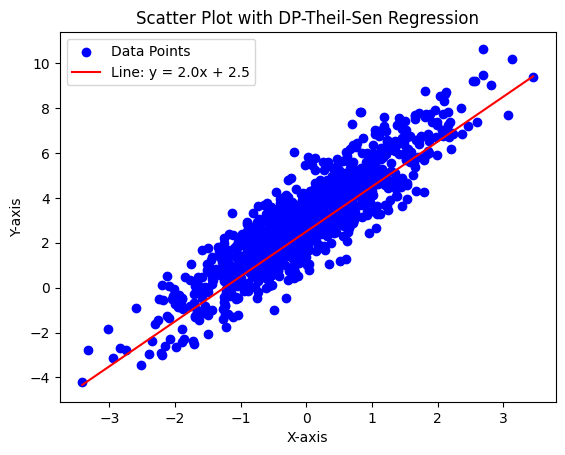

In [105]:
x = data[:, 0]
y = data[:, 1]

m, b = coef
line_x = np.linspace(np.min(x), np.max(x), 100)
line_y = m * line_x + b

plt.scatter(x, y, color='blue', label='Data Points')
plt.plot(line_x, line_y, color='red', label=f'Line: y = {m}x + {b}')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with DP-Theil-Sen Regression')
plt.legend()

plt.show()


The DP regression results align well with our synthetic data. Now let's apply the method to some real data. 

## Conclusion

In this notebook, we illustrated how to create and apply OpenDP methods to create differentially private regressions. 